In [2]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.Framework_future import AdversarialRegulariser
from ClassFiles.ut import l2
from one_step_EM import oneStepEM
from ClassFiles import registration
from ClassFiles.ut import locate_gt

In [9]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/'
#path=base_path+'Refine3D/1H12/1H12_mult002_it007_half2_class001_external_reconstruct.star'
#path=base_path+'Refine3D/1H12/1H12_mult005_it001_half1_class001_external_reconstruct.star'
path=base_path+'3PE7/3PE7_mult002_it010_half1_class001_external_reconstruct.star'
# sgd_path='/local/scratch/public/sl767/MRC_Data/Data_002_10k/SGD/1O20/1O20_mult002_it300_class001.mrc'

pdb = '3PE7'
ground_truth_path=locate_gt(pdb)

In [10]:
file=load_star(path)

In [11]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
   data_real = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
   data_im = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
   kernel = mrc.data
with mrcfile.open(ground_truth_path) as mrc:
   ground_truth = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
   naive_recon = mrc.data
with mrcfile.open('/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/3PE7/3PE7_mult002_class001.mrc') as mrc:
    final_EM_reco = mrc.data
tau2 = file['external_reconstruct_tau2']['rlnReferenceTau2']
# with mrcfile.open(path) as mrc:
#     sgd_res = mrc.data
# with mrcfile.open(sgd_path) as mrc:
#    sgd_data = mrc.data
#print(tau2)
#print(file['external_reconstruct_tau2']['rlnSpectralIndex'])

In [12]:
complex_data=data_real + 1j * data_im

In [45]:
REGULARIZATION=.1
set_off=REGULARIZATION*kernel.max()
reg_kernel = kernel+set_off

In [46]:
# Initial guess for iterative algorithm
reco = np.divide(complex_data,reg_kernel)
ini = np.copy(reco)
# reco = np.fft.rfftn(np.fft.ifftshift(sgd_data))
# ini = np.copy(reco)
reco_real = np.fft.fftshift(np.fft.irfftn(reco))

Build visualization tool

In [47]:
def vis(data, fourier=True):
    if fourier:
        data = np.fft.fftshift(np.fft.irfftn(data))
    #plt.imshow(im[...,45])
    plt.imshow(np.mean(data, axis=-1))

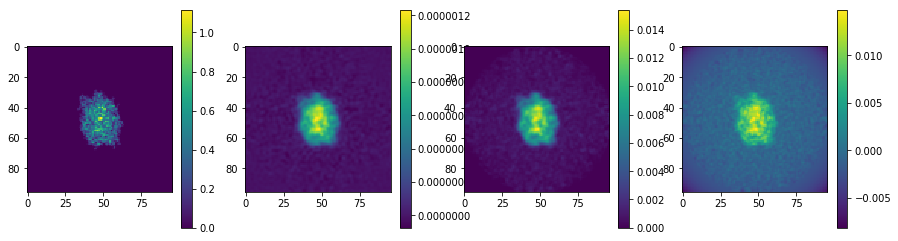

In [53]:
plt.figure(figsize=(15,4))
plt.subplot(141)
vis(ground_truth, fourier=False)
plt.colorbar()
plt.subplot(142)
vis(reco_real, fourier=False)
plt.colorbar()
plt.subplot(143)
vis(np.maximum(naive_recon, 0), fourier=False)
plt.colorbar()
plt.subplot(144)
vis(final_EM_reco, fourier=False)
plt.colorbar()

In [49]:
quotient = np.mean(naive_recon)/np.mean(reco_real)
print(np.mean(naive_recon))
print(np.mean(reco_real))
print(quotient)

-0.000455317
4.60701e-08
-9883.13


In [50]:
print(tau2[0])
print(1/(2*float(tau2[0])))
print(kernel[0, 0, 0])
print(reg_kernel[0,0,0])
print(reg_kernel[0,0,0]/ (kernel[0,0,0] + 1/(2*float(tau2[0]))))
tmp = reg_kernel[0,0,0]/ (kernel[0,0,0] + 1/(2*float(tau2[0]))) 
print(quotient/tmp)

8.446933e-05
5919.308227021571
1.18268e+07
1.56706e+07
1.32435121019
-7462.61782906


In [51]:
print(np.max(naive_recon))
print(np.max(reco_real))
print(np.max(naive_recon)/np.max(reco_real))

0.0642779
5.52482e-06
11634.4


In [123]:
print(l2(naive_recon))
print(l2(reco_real))
print(l2(naive_recon)/l2(reco_real))

4.78171
0.000451691
10586.3


In [124]:
print(np.min(naive_recon))
print(np.min(reco_real))
print(np.min(naive_recon)/np.min(reco_real))

-0.0244662
-1.39003e-06
17601.2


In [85]:
print(96**2)
print((2*np.pi)**1.5)
print((96*2*np.pi)**1.5)

9216
15.749609945722419
14814.147077715068


In [86]:
Registrator = registration.Registrator()

KeyboardInterrupt: 

In [ ]:
def full_eval(x):
    

In [ ]:
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/SGD_Trained/phase_augmentation/'
regularizer = AdversarialRegulariser(saves_path)

In [ ]:
STEP_SIZE=5e4
def grad(image):
    grad = regularizer.evaluate(image)
    return grad

In [ ]:
# plt.subplot(131)
# vis(ini)
# plt.subplot(132)
# gradient = grad(reco)
# vis(gradient)
# reco=reco-STEP_SIZE*(gradient-9.0675324549243569e-07*ini)
# plt.subplot(133)
# vis(reco)

In [ ]:
# for k in range(500):
#     STEP_SIZE=1e-2
#     gradient = grad(reco)
#     reco = reco - STEP_SIZE*(gradient*(96**3)+7*(reco-ini))
#     if k%50==0:
#         plt.figure(k)
#         plt.subplot(121)
#         vis(reco)
#         plt.subplot(122)
#         vis(ini)
#         plt.show()

In [ ]:
# reco = np.copy(ini) * 1e-9
tikhonov_kernel = kernel + 1e6
precondioner = np.abs(np.divide(1, tikhonov_kernel))
precondioner /= precondioner.max()
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**1.5)
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96**3

for k in range(10000):
    STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)
    
    g1 = (1 / precondioner ** 2) * 0.005 * grad(reco) * ADVERSARIAL_SCALE
    g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
    reco = reco - STEP_SIZE * precondioner * g
    
    if 0:
        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    #reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%11==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(IMAGING_SCALE*tikhonov)
        plt.colorbar()
        plt.subplot(152)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(153)
        vis(IMAGING_SCALE*g1)
        plt.colorbar()
        plt.subplot(154)
        vis(IMAGING_SCALE*precondioner *g)
        plt.colorbar()
        plt.subplot(155)
        vis(IMAGING_SCALE*(reco - tikhonov))
        plt.colorbar()
        plt.show()

l2(np.multiply(reco, kernel)-complex_data)

In [ ]:
plt.imshow(np.log10(1 + np.abs(tikhonov_kernel[..., 0])))
plt.colorbar()

In [ ]:
norm_grad = l2(grad(ini))
print(norm_grad*(96**1.5))

In [ ]:
norm_grad_data = l2(np.multiply(kernel,ini)-complex_data)
print(norm_grad_data)

In [ ]:
l2(np.multiply(kernel, ini))

In [ ]:
l2(complex_data) * 96 ** 3

In [ ]:
l2(np.divide(complex_data, kernel+100))

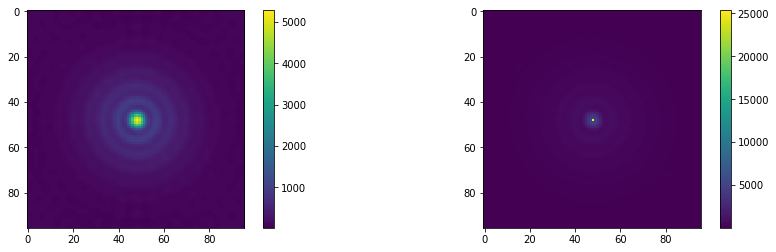

In [92]:
plt.figure(figsize=(15,4))
plt.subplot(121)
vis(kernel, fourier=True)
plt.colorbar()
plt.subplot(122)
vis(reg_kernel, fourier=True)
plt.colorbar()

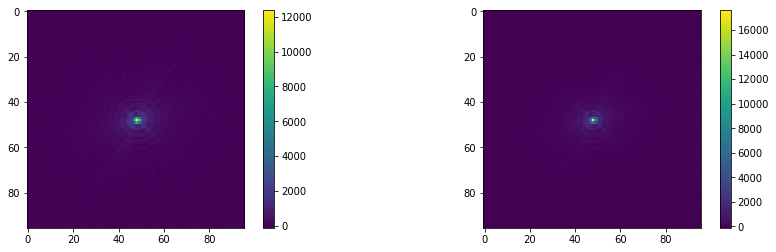

In [104]:
plt.figure(figsize=(15,4))
plt.subplot(121)
vis(kernel, fourier=True)
plt.colorbar()
plt.subplot(122)
vis(reg_kernel, fourier=True)
plt.colorbar()

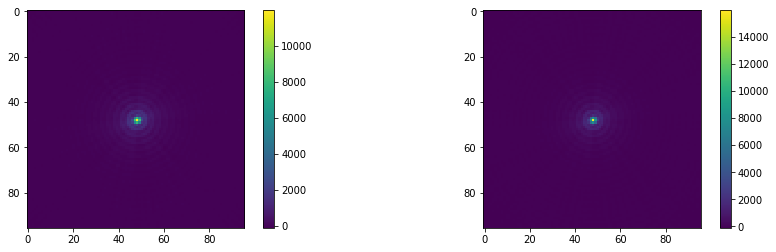

In [98]:
plt.figure(figsize=(15,4))
plt.subplot(121)
vis(kernel, fourier=True)
plt.colorbar()
plt.subplot(122)
vis(reg_kernel, fourier=True)
plt.colorbar()

In [142]:
np.argmax(kernel)

0

In [111]:
N = 96
dist = np.zeros([N] * 3)
for i in np.arange(N):
    for j in np.arange(N):
        for k in np.arange(N):
            dist[i, j, k] = np.floor(np.sqrt(i**2 + j**2 + k **2))

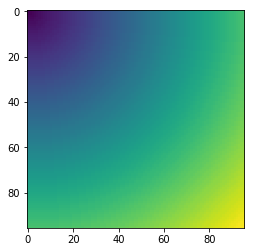

In [112]:
plt.imshow(dist[..., 0])

In [141]:
kernel.shape

(96, 96, 49)

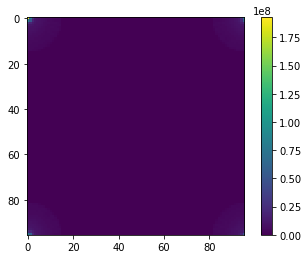

In [152]:
plt.imshow(kernel[:, :, 0])
plt.colorbar()

1.9267994e+08

In [170]:
11607 / ((2*np.pi) ** 1.5)

736.9706322887349

In [33]:
for k in range(1, 20):
    if k<10:
        K = '0' + str(k)
    else:
        K = k
    path=base_path+'3PE7/3PE7_mult002_it0{}_half1_class001_external_reconstruct.star'.format(K)
    file=load_star(path)
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
       data_real = mrc.data
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
       data_im = mrc.data
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
       kernel = mrc.data
    with mrcfile.open(ground_truth_path) as mrc:
       ground_truth = mrc.data
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
       naive_recon = mrc.data
    with mrcfile.open('/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/3PE7/3PE7_mult002_class001.mrc') as mrc:
        final_EM_reco = mrc.data
    tau2 = file['external_reconstruct_tau2']['rlnReferenceTau2']
    tau2_fudge = file['external_reconstruct_general']['rlnTau2FudgeFactor'] 
# with mrcfile.open(path) as mrc:
#     sgd_res = mrc.data
# with mrcfile.open(sgd_path) as mrc:
#    sgd_data = mrc.data
    complex_data=data_real + 1j * data_im
    REGULARIZATION=.0001
    set_off=REGULARIZATION*kernel.max()
    reg_kernel = kernel+set_off
    # Initial guess for iterative algorithm
    reco = np.divide(complex_data, reg_kernel)
    ini = np.copy(reco)
    # reco = np.fft.rfftn(np.fft.ifftshift(sgd_data))
    # ini = np.copy(reco)
    reco_real = np.fft.fftshift(np.fft.irfftn(reco))
    quotient = np.mean(naive_recon)/np.mean(reco_real)
    q2 = l2(naive_recon)/l2(reco_real)
    #    print(path)
#    print(np.mean(naive_recon), np.mean(reco_real), tau2[0], kernel[0,0,0], reg_kernel[0,0,0], reg_kernel[0,0,0]/ (kernel[0,0,0] + 1/(2*float(tau2[0]))))
#    print(np.mean(reco_real))  
#    print(q2)
#    print(tau2_fudge)
#    print(tau2[0])
#    print(1/(2*float(tau2[0])))
#    print(kernel[0, 0, 0])
#    print(reg_kernel[0,0,0])
#    print(reg_kernel[0,0,0]/ (kernel[0,0,0] + 1/(2*float(tau2[0]))))
#    tmp = reg_kernel[0,0,0]/ (kernel[0,0,0] + 1/(2*float(tau2[0]))) 
#    print(quotient/tmp)
#    print(np.sum(naive_recon), complex_data[0,0,0]/(kernel[0,0,0] + 1/(2*float(tau2[0]))))

1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000
1.000000


In [55]:
naive_recon.shape

(96, 96, 96)

In [8]:
96 ** 2

9216

In [63]:
import platform
platform.node()

'motel'